In [ ]:
import os
import json

# Move kaggle.json to the right directory
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/

# Set correct permissions
!chmod 600 ~/.kaggle/kaggle.json

# Check if Kaggle API is working
!kaggle datasets list

In [ ]:
!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset

Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset
License(s): CC0-1.0


In [ ]:
import zipfile

with zipfile.ZipFile("brain-tumor-mri-dataset.zip", 'r') as zip_ref:
    zip_ref.extractall("brain_tumor_data")

# Check extracted files
os.listdir("brain_tumor_data")
train_dir = os.path.join("brain_tumor_data", "Training")
test_dir = os.path.join("brain_tumor_data", "Testing")

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#Image Preprocessing & Augmentation
image_size=(224,224)
btch_size=32

#Training Dataset
train_datagen=ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest')

#Testing Dataset
test_datagen=ImageDataGenerator(rescale=1./255)

#Load Images from Dataset
train_generator=train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=btch_size,
    class_mode="categorical"
)

test_generator=test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=btch_size,
    class_mode="categorical"
)

Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten

#Load VGG16 Model
base_model=VGG16(weights="imagenet", include_top=False, input_shape=(224,224,3))

#Freeze Base Model Layers
for layer in base_model.layers:
  layer.trainable=False

#Add Custom Classification Layers
x=Flatten()(base_model.output) #Converts the feature maps from CNN to a 1D vector.
x=Dense(512,activation="relu")(x) #Adds a fully connected layer with 512 neurons using ReLU activation.
x=Dropout(0.5)(x) #Drops 50% of neurons randomly to prevent overfitting.
x=Dense(256, activation="relu")(x) #Adds another fully connected layer with 256 neurons.
x=Dense(4, activation="softmax")(x) #The final output layer with 4 neurons (one for each tumor type) using Softmax activation

#Create Final Model
model=Model(inputs=base_model.input,outputs=x) #Combines the VGG16 feature extractor with the new fully connected layers.

#Compile Model
model.compile(optimizer="adam",loss="categorical_crossentropy", metrics=["accuracy"])
#optimizer="adam" Uses the Adam optimizer, which adapts learning rates automatically.
#loss="categorical_crossentropy" Since we have 4 classes, we use categorical cross-entropy loss.
#metrics=["accuracy"] Tracks accuracy during training.

#Train Model
history=model.fit(
    train_generator,
    epochs=10,
    validation_data=test_generator
)

#Save Model
model.save("brain_tumor_vgg16_model.keras")

Epoch 1/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 89s 482ms/step - accuracy: 0.5953 - loss: 1.4670 - val_accuracy: 0.8024 - val_loss: 0.5063
Epoch 2/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 84s 469ms/step - accuracy: 0.7798 - loss: 0.5790 - val_accuracy: 0.8215 - val_loss: 0.4550
Epoch 3/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 84s 469ms/step - accuracy: 0.7636 - loss: 0.6045 - val_accuracy: 0.7834 - val_loss: 0.5266
Epoch 4/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 85s 477ms/step - accuracy: 0.7646 - loss: 0.5818 - val_accuracy: 0.7788 - val_loss: 0.6094
Epoch 5/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 85s 473ms/step - accuracy: 0.7756 - loss: 0.5450 - val_accuracy: 0.7941 - val_loss: 0.4930
Epoch 6/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 84s 468ms/step - accuracy: 0.7945 - loss: 0.5047 - val_accuracy: 0.8330 - val_loss: 0.4130
Epoch 7/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 84s 469ms/step - accuracy: 0.7822 - loss: 0.5246 - val_accuracy: 0.8268 - val_loss: 0.4256
Epoch 8/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 86s 481ms/step - accuracy: 0.8099 - loss: 0

In [ ]:
# Print Final Training & Validation Accuracy
final_train_acc = history.history['accuracy'][-1]  # Last epoch's training accuracy
final_val_acc = history.history['val_accuracy'][-1]  # Last epoch's validation accuracy

print(f"Final Training Accuracy: {final_train_acc * 100:.2f}%")
print(f"Final Validation Accuracy: {final_val_acc * 100:.2f}%")

Final Training Accuracy: 81.53%
Final Validation Accuracy: 86.19%


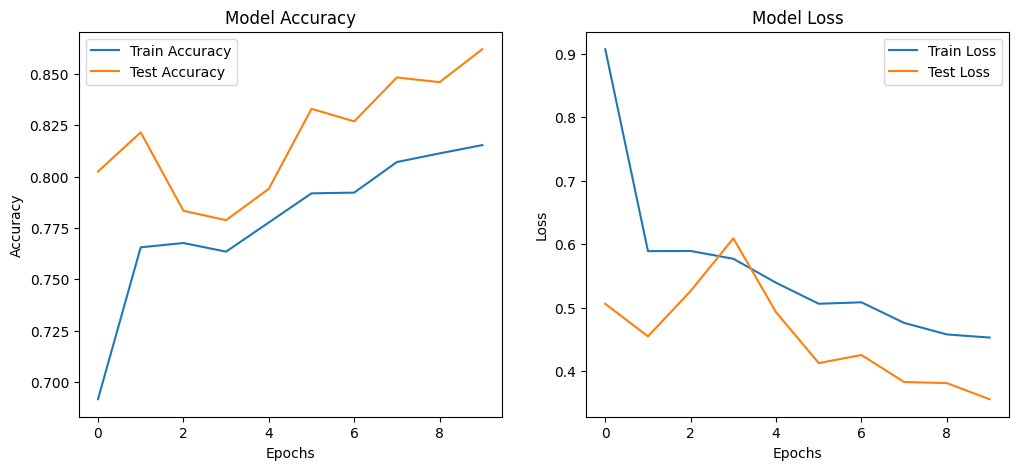

In [ ]:
import matplotlib.pyplot as plt

# Plot Accuracy & Loss
def plot_history(history):
    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Test Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Model Accuracy')

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Model Loss')

    plt.show()

plot_history(history)


In [ ]:
!pip install gradio

In [ ]:
import gradio as gr
import numpy as np
import random
import os
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
from PIL import Image

# Define test dataset path
test_dir = "/content/brain_tumor_data/Testing"

# Load trained VGG16 model
model = load_model("/content/brain_tumor_vgg16_model.keras")

# Get class labels
class_labels = sorted(os.listdir(test_dir))

# Function to generate Grad-CAM heatmap
def generate_gradcam(img_array, model, class_index):
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer("block5_conv3").output, model.output])

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, class_index]

    grads = tape.gradient(loss, conv_outputs)[0]
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    pooled_grads = pooled_grads.numpy()
    conv_outputs = conv_outputs.numpy()

    heatmap = np.mean(conv_outputs * pooled_grads, axis=-1)[0]
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)

    heatmap = cv2.resize(heatmap, (224, 224))

    return heatmap

# Function to generate Saliency Map
def generate_saliency_map(img_array, model, class_index):
    img_tensor = tf.convert_to_tensor(img_array, dtype=tf.float32)
    with tf.GradientTape() as tape:
        tape.watch(img_tensor)
        prediction = model(img_tensor)
        loss = prediction[:, class_index]

    grads = tape.gradient(loss, img_tensor)
    saliency = tf.reduce_max(tf.abs(grads), axis=-1)[0].numpy()

    saliency = (saliency - saliency.min()) / (saliency.max() - saliency.min())

    return saliency

# Function to randomly pick an image and make a prediction
def predict_random_image():
    try:
        # Randomly select a class folder
        random_class = random.choice(class_labels)
        class_path = os.path.join(test_dir, random_class)

        # Randomly select an image from that class
        random_image = random.choice(os.listdir(class_path))
        image_path = os.path.join(class_path, random_image)

        # Load and preprocess the image
        img = Image.open(image_path).convert("RGB")
        img_resized = img.resize((224, 224))
        img_array = image.img_to_array(img_resized)
        img_array = np.expand_dims(img_array, axis=0) / 255.0

        # Predict using the model
        prediction = model.predict(img_array)[0]
        predicted_class = class_labels[np.argmax(prediction)]
        confidence = np.max(prediction) * 100

        # Generate Grad-CAM heatmap
        heatmap = generate_gradcam(img_array, model, np.argmax(prediction))
        heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
        superimposed_img = cv2.addWeighted(np.array(img_resized), 0.6, heatmap_colored, 0.4, 0)
        gradcam_img = Image.fromarray(superimposed_img)

        # Generate Saliency Map
        saliency_map = generate_saliency_map(img_array, model, np.argmax(prediction))

        # Convert Saliency Map to Image
        plt.figure(figsize=(5, 5))
        plt.imshow(saliency_map, cmap="jet")
        plt.axis("off")
        plt.xticks([])
        plt.yticks([])
        saliency_path = "/content/saliency_map.png"
        plt.savefig(saliency_path,bbox_inches='tight', pad_inches=0, transparent=True)
        plt.close()

        # Generate prediction text
        result_text = f"Predicted Tumor Type: {predicted_class}\nConfidence: {confidence:.2f}%\nActual Tumor Type: {random_class}"

        # Create bar chart for confidence scores
        plt.figure(figsize=(6, 4))
        plt.bar(class_labels, prediction, color="darkgreen", alpha=0.7)
        plt.xlabel("Tumor Type")
        plt.ylabel("Prediction Confidence")
        plt.title("Model Confidence Levels")
        plt.xticks(rotation=30)
        plt.tight_layout()
        chart_path = "/content/pred_chart.png"
        plt.savefig(chart_path)
        plt.close()

        return img, gradcam_img, saliency_path, result_text, chart_path

    except Exception as e:
        return None, None, None, f"Error: {str(e)}", None

# Define custom CSS for styling
custom_css = """
h1 { text-align: center; color: white; font-size: 36px; font-weight: bold; }
p { text-align: center; font-size: 18px; color: #3C3C3C; }
button { background-color: #212d2e; color: white; font-size: 18px; padding: 12px 24px; border-radius: 12px; border: none; transition: 0.3s; }
img { width: auto; height: auto; max-width: 100%; max-height: 100%; border: 4px solid #3C3C3C; border-radius: 12px; box-shadow: 0px 4px 10px rgba(0, 0, 0, 0.2); }
"""

with gr.Blocks(css=custom_css) as interface:
    gr.Markdown("# Brain Tumor Detection with VGG16", elem_id="title")
    gr.Markdown("### This AI model randomly selects an MRI scan from the test dataset and predicts its category.")

    with gr.Row():
        img_display = gr.Image(label="Original MRI Scan", width=400, height=400)
        gradcam_display = gr.Image(label="Grad-CAM Heatmap", width=400, height=400)
        saliency_display = gr.Image(label="Saliency Map", width=400, height=400)

    with gr.Row():  # Place Prediction Results and Chart Side by Side
        result_text = gr.Textbox(label="Prediction Result", lines=4)
        confidence_chart = gr.Image(label="Prediction Confidence Chart", width=500, height=400)

    with gr.Row():
        predict_button = gr.Button("Generate Prediction")

    # Link button to function
    predict_button.click(
        predict_random_image,
        inputs=[],
        outputs=[img_display, gradcam_display, saliency_display, result_text, confidence_chart]
    )

# Launch the Gradio app
interface.launch(share=True)